# Argentina Training Data

In [196]:
from tqdm.notebook import tqdm

import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import seaborn.timeseries
import sys

sys.path.append("..")

from src.datasets_labeled import labeled_datasets
from src.ETL.constants import CROP_PROB, CROP_TYPE, FEATURE_PATH, BANDS, LON, LAT

In [18]:
Argentina_data = [d for d in labeled_datasets if d.dataset == "Argentina_Buenos_Aires"][0]

In [19]:
def get_labelled_array(save_path):
    with open(save_path, "rb") as f:
        return pickle.load(f).labelled_array

df = Argentina_data.load_labels()
df["labelled_array"] = np.vectorize(get_labelled_array, otypes=[np.ndarray])(df[FEATURE_PATH])
df["labelled_array_flattened"] = np.vectorize(np.matrix.flatten, otypes=[np.ndarray])(df["labelled_array"])

In [20]:
df[CROP_PROB].value_counts(normalize=True)

0.0    0.512158
1.0    0.487842
Name: crop_probability, dtype: float64

<AxesSubplot:title={'center':'Crop Type Distribution'}>

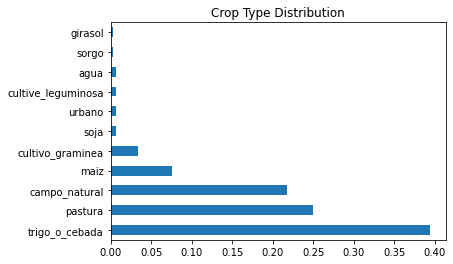

In [102]:
df[CROP_TYPE].value_counts(normalize=True).plot(kind="barh", title="Crop Type Distribution")

In [22]:
df["NDVI_series"] = df["labelled_array"].apply(lambda x: x[:, -1])
df["mean_bands"] = df["labelled_array"].apply(lambda x: x.mean(axis=0))

In [230]:
months = ["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"]

In [152]:
months.index(["May"])

ValueError: ['May'] is not in list

In [29]:
df_long_data = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    row_dict = row.to_dict()
    for month, ndvi in zip(months, row_dict["NDVI_series"]):
        new_row = row_dict.copy()
        new_row["month"] = month
        new_row["month_num"] = 
        new_row["ndvi"] = ndvi
        df_long_data.append(new_row)
df_NDVI = pd.DataFrame(df_long_data)

  0%|          | 0/658 [00:00<?, ?it/s]

In [156]:
df_NDVI["month_num"] = df_NDVI["month"].apply(lambda x: months.index(x) + 4)

In [32]:
df_long_data2 = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    row_dict = row.to_dict()
    for name, value in zip(BANDS, row_dict["mean_bands"][:-1]):
        new_row = row_dict.copy()
        new_row["band_name"] = name
        new_row["band_value"] = value
        df_long_data2.append(new_row)
df_BANDS = pd.DataFrame(df_long_data2)

  0%|          | 0/658 [00:00<?, ?it/s]

# NDVI Trends

In [166]:
def _plot_range_band(*args, central_data=None, ci=None, data=None, **kwargs):
    upper = data.max(axis=0)
    lower = data.min(axis=0)
    #import pdb; pdb.set_trace()
    ci = np.asarray((lower, upper))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
    
seaborn.timeseries._plot_range_band = _plot_range_band

<AxesSubplot:xlabel='month_num', ylabel='ndvi'>

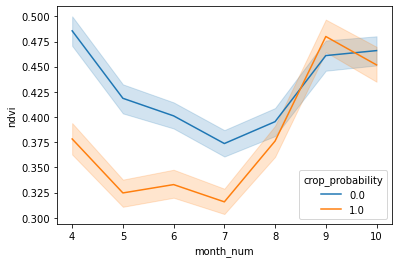

In [157]:
sns.lineplot(data=df_NDVI, x="month_num", y="ndvi", hue=CROP_PROB)

In [188]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)

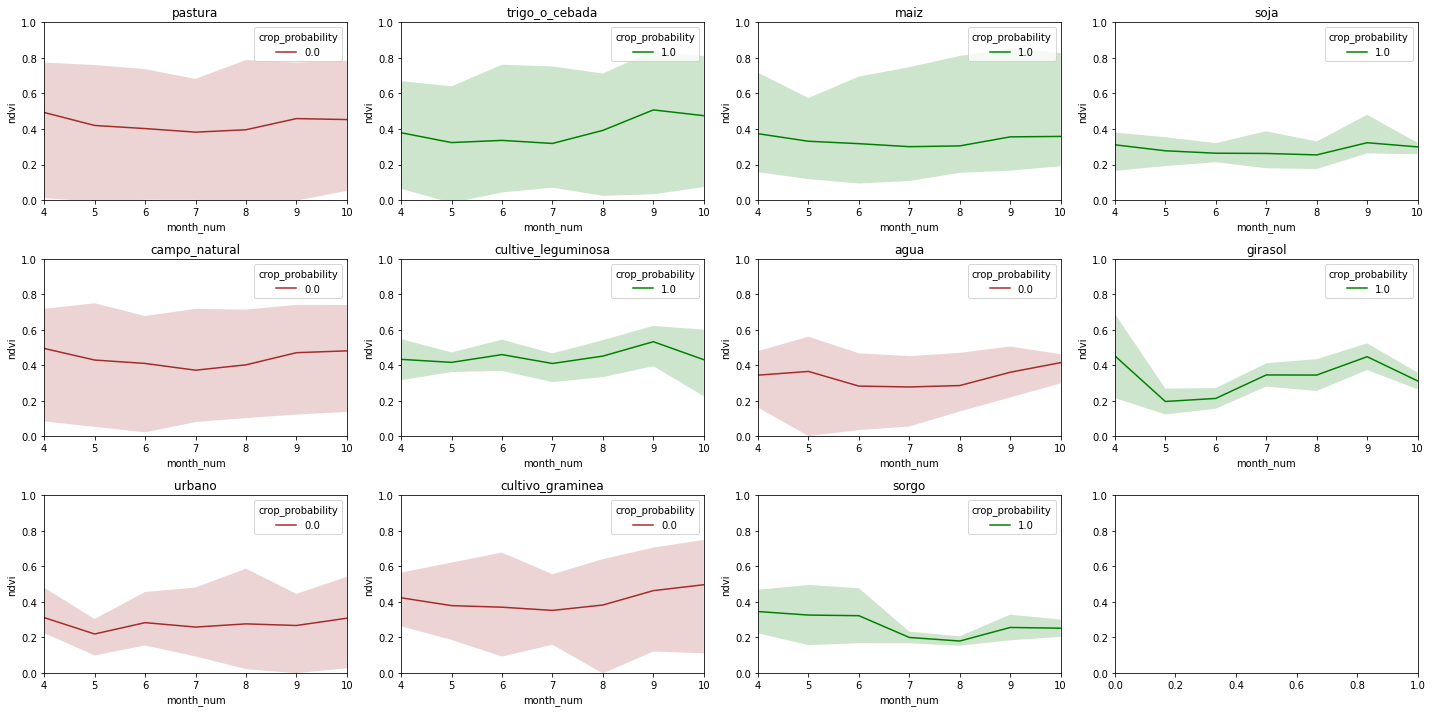

In [189]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20,10))
for i, crop_type in enumerate(df[CROP_TYPE].unique()):    
    ax = axs[i%3][i//3]
    crop_type_ndvi = df_NDVI[df_NDVI[CROP_TYPE] == crop_type].copy()
    if crop_type_ndvi[CROP_PROB].sum() > 0:
        color = "green"
    else:
        color= "brown"
    
    crop_type_ndvi['Unit'] = crop_type_ndvi.groupby(['month']).cumcount()
    sns.timeseries.tsplot(data=crop_type_ndvi, 
                          time="month_num", 
                          condition=CROP_PROB, 
                          unit="Unit", 
                          value="ndvi", 
                          err_style="range_band", 
                          n_boot=0, 
                          color=color,
                          ax=ax)

    ax.set_title(crop_type)
    ax.set(ylim=(0, 1.0))

plt.tight_layout()

# Showing one point

In [203]:
import folium
import os
from dotenv import load_dotenv

load_dotenv()

True

In [204]:
map_box_token = os.environ.get("MAPBOX_TOKEN")
mapbox_kwargs = {
    "tiles": 'https://api.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token='+map_box_token,
    "attr": 'mapbox.com',
    "name": "Mapbox"
}

In [216]:
row = df.iloc[30]
row

lon                                                                  -58.7756
lat                                                                  -35.4423
start_date                                                         2021-04-18
end_date                                                           2021-11-14
source                                             bc_mapeo_del_cultivo_0.csv
crop_probability                                                            1
num_labelers                                                                1
subset                                                               training
crop_type                                                      trigo_o_cebada
country                                                             Argentina
dataset                                                Argentina_Buenos_Aires
filename                    lat=-35.4422745_lon=-58.7755722_date=2021-04-1...
feature_dir                                                  ../

In [223]:
def map_with_point(row, zoom):
    m = folium.Map(location=(row[LAT], row[LON]), zoom_start=zoom, **mapbox_kwargs)
    folium.Marker(location=[row[LAT], row[LON]]).add_to(m)
    return m

In [224]:
map_with_point(row, zoom=8)

In [225]:
map_with_point(row, zoom=16)

Text(0.5, 1.0, 'Mean Bands for -35.442274499999996, -58.775572200000006')

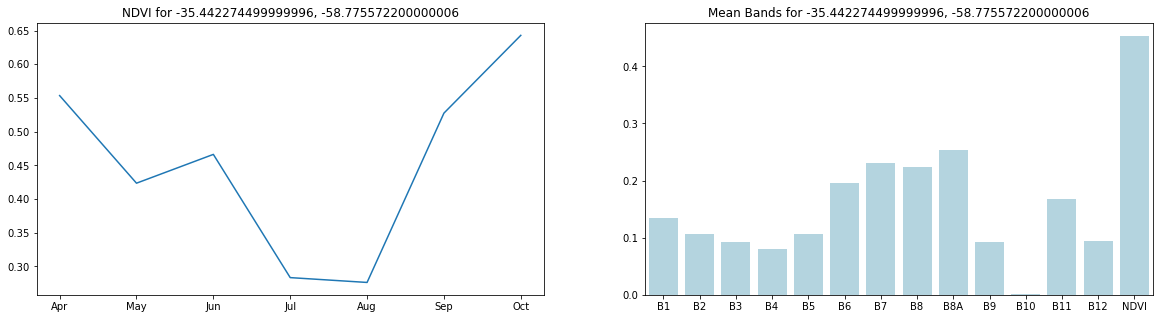

In [250]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
sns.lineplot(x=months, y=row["NDVI_series"], ax=axs[0]);
axs[0].set_title(f"NDVI for {row[LAT]}, {row[LON]}")
sns.barplot(x=BANDS + ["NDVI"], y=row["labelled_array"].mean(axis=0), ax=axs[1], color='lightblue')
axs[1].set_title(f"Mean Bands for {row[LAT]}, {row[LON]}")